In [ ]:
# !pip install -q transformers torchvision timm scikit-learn matplotlib pillow tqdm

import os
import math
import random
from pathlib import Path
from typing import List, Tuple, Optional

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
from PIL import Image

from tqdm import tqdm

from transformers import ViTForImageClassification, ViTModel, AutoImageProcessor, set_seed
set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [ ]:
# === Part 1: Pretrained ViT → top-1 predictions for 1–3 images ===
# pip install transformers torch torchvision pillow  # (if needed)

import torch
from PIL import Image
from transformers import ViTForImageClassification, AutoImageProcessor

# 1) Choose a small ImageNet-pretrained ViT + its processor
MODEL_NAME = "google/vit-base-patch16-224"  # patch size 16, input size 224
device = "cuda" if torch.cuda.is_available() else "cpu"

processor = AutoImageProcessor.from_pretrained(MODEL_NAME)
model = ViTForImageClassification.from_pretrained(MODEL_NAME).to(device).eval()
id2label = model.config.id2label  # maps class index -> readable label

# 2) Provide 1–3 image paths (any natural photos). The processor will resize to 224x224.
image_paths = [
    "/content/dog-puppy-on-garden-royalty-free-image-1586966191.avif",
    "/content/kitty-cat-kitten-pet-45201.jpg",
    # "path/to/your_img3.jpg",
]

# 3) Load images (RGB)
images = [Image.open(p).convert("RGB") for p in image_paths]

# 4) Preprocess + run inference
inputs = processor(images=images, return_tensors="pt").to(device)
with torch.no_grad():
    logits = model(**inputs).logits          # [B, 1000] for ImageNet-1k
    probs = logits.softmax(dim=-1)           # convert to probabilities
    top1_ids = probs.argmax(dim=-1)          # index of top-1 class

# 5) Print a tiny results table
print("\n=== ViT top-1 predictions ===")
for i, path in enumerate(image_paths):
    cls_id = top1_ids[i].item()
    label = id2label[cls_id]
    conf  = probs[i, cls_id].item()
    print(f"Image {i+1}: {path}")
    print(f"  Top-1: {label}  (p={conf:.3f})")
    print(f"  Reasonable?  <-- fill Y/N after looking at the image\n")



Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]


=== ViT top-1 predictions ===
Image 1: /content/dog-puppy-on-garden-royalty-free-image-1586966191.avif
  Top-1: golden retriever  (p=0.888)
  Reasonable?  <-- fill Y/N after looking at the image

Image 2: /content/kitty-cat-kitten-pet-45201.jpg
  Top-1: lynx, catamount  (p=0.509)
  Reasonable?  <-- fill Y/N after looking at the image



Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


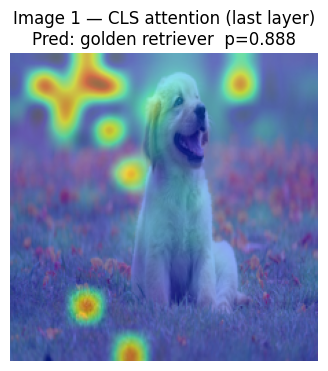

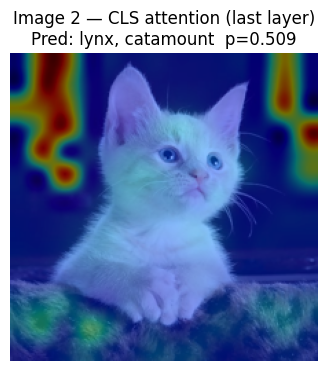

In [ ]:
# === Part 2 (simple & reliable): CLS → patch attention via a dedicated backbone ===
# Reuses: MODEL_NAME, processor, images, device

# 1) Load a backbone that DEFINITELY returns attentions
vit_backbone = ViTModel.from_pretrained(MODEL_NAME, output_attentions=True).to(device).eval()

def cls_attn_heatmap(img_pil):
    """
    Return (H,W) heatmap in [0,1] at the model's input size (usually 224x224).
    """
    inputs_ = processor(images=img_pil, return_tensors="pt").to(device)
    with torch.no_grad():
        out = vit_backbone(**inputs_)  # output_attentions=True baked into the model
    assert out.attentions is not None, "Attentions are None; backbone didn't return them."
    att_last = out.attentions[-1]                 # (B=1, heads, seq, seq)
    att_mean = att_last.mean(dim=1)               # average heads -> (1, seq, seq)
    cls_to_patches = att_mean[:, 0, 1:]           # FROM CLS row (0) TO patch tokens (1..)
    image_size = vit_backbone.config.image_size   # 224
    patch = vit_backbone.config.patch_size        # 16
    Hp = Wp = image_size // patch                 # 14 x 14
    heat = cls_to_patches.reshape(1, 1, Hp, Wp)
    # normalize to [0,1]
    heat = heat - heat.min()
    heat = heat / (heat.max() + 1e-6)
    # upsample to image size for overlay
    heat_up = F.interpolate(heat, size=(image_size, image_size),
                            mode="bicubic", align_corners=False)
    return heat_up.squeeze().detach().cpu().numpy().astype(np.float32)

def show_overlay(img_pil, heat, title=None, alpha=0.45, cmap="jet"):
    img_resized = img_pil.resize((heat.shape[1], heat.shape[0]), Image.BICUBIC)
    plt.figure(figsize=(4,4))
    plt.imshow(img_resized)
    plt.imshow(heat, cmap=cmap, alpha=alpha, interpolation="bilinear")
    plt.axis("off")
    if title: plt.title(title)
    plt.show()

# 2) Run on your images
for i, img in enumerate(images):
    heat = cls_attn_heatmap(img)
    # Optional: reuse predictions you already computed
    cls_id = int(top1_ids[i])
    title = f"Image {i+1} — CLS attention (last layer)\nPred: {id2label[cls_id]}  p={probs[i, cls_id].item():.3f}"
    show_overlay(img, heat, title=title)


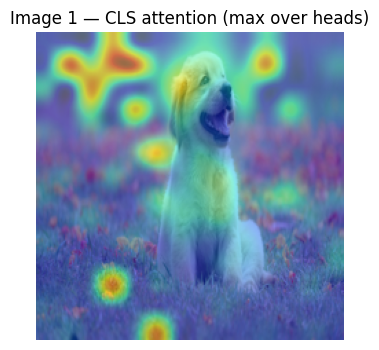

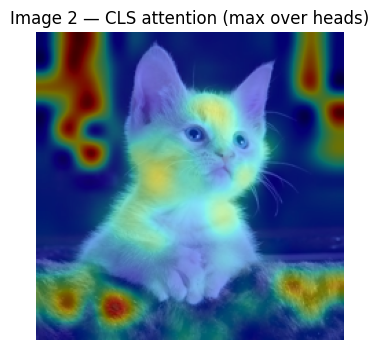

In [ ]:
# A) Max over heads (often looks more object-centric)

import torch, torch.nn.functional as F
import numpy as np, matplotlib.pyplot as plt
from PIL import Image

def overlay(img, heat, title=None, alpha=0.45):
    img = img.resize((heat.shape[1], heat.shape[0]), Image.BICUBIC)
    plt.figure(figsize=(4,4)); plt.imshow(img); plt.imshow(heat, cmap="jet", alpha=alpha)
    plt.axis("off");
    if title: plt.title(title);
    plt.show()

def cls_attn_max_head(img):
    inputs = processor(images=img, return_tensors="pt").to(device)
    with torch.no_grad():
        out = vit_backbone(**inputs)  # attentions returned
    att_last = out.attentions[-1][0]          # (heads, seq, seq)
    cls2patch_all = att_last[:, 0, 1:]        # (heads, num_patches)
    cls2patch = cls2patch_all.max(dim=0).values  # max over heads
    size = vit_backbone.config.image_size
    p = vit_backbone.config.patch_size
    Hp = Wp = size // p
    heat = cls2patch.reshape(1,1,Hp,Wp)
    heat = (heat - heat.min()) / (heat.max() - heat.min() + 1e-6)
    heat_up = F.interpolate(heat, size=(size,size), mode="bicubic", align_corners=False)
    return heat_up.squeeze().cpu().numpy()

for i, img in enumerate(images):
    heat = cls_attn_max_head(img)
    overlay(img, heat, title=f"Image {i+1} — CLS attention (max over heads)")


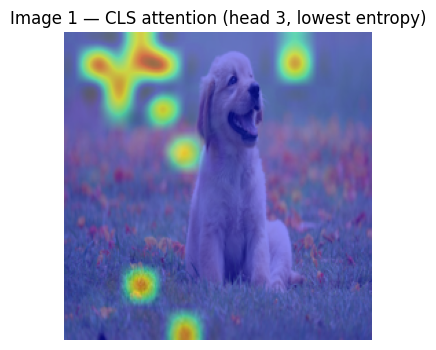

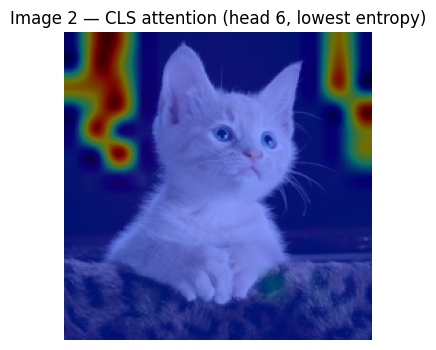

In [ ]:
#) “Best” single head (lowest entropy = most focused)

import torch, torch.nn.functional as F, numpy as np, matplotlib.pyplot as plt
from PIL import Image

def cls_attn_best_head(img):
    inputs = processor(images=img, return_tensors="pt").to(device)
    with torch.no_grad():
        out = vit_backbone(**inputs)
    att = out.attentions[-1][0]               # (heads, seq, seq)
    cls_all = att[:, 0, 1:]                   # (heads, num_patches)
    # pick the head whose CLS→patch distribution has lowest entropy
    p = cls_all / (cls_all.sum(dim=-1, keepdim=True) + 1e-12)
    ent = -(p * (p + 1e-12).log()).sum(dim=-1)  # (heads,)
    h = int(ent.argmin())
    cls_vec = cls_all[h]
    size = vit_backbone.config.image_size; px = vit_backbone.config.patch_size
    Hp = Wp = size // px
    heat = cls_vec.reshape(1,1,Hp,Wp)
    heat = (heat - heat.min()) / (heat.max() - heat.min() + 1e-6)
    heat_up = F.interpolate(heat, size=(size,size), mode="bicubic", align_corners=False)
    return heat_up.squeeze().cpu().numpy(), h

for i, img in enumerate(images):
    heat, h = cls_attn_best_head(img)
    overlay(img, heat, title=f"Image {i+1} — CLS attention (head {h}, lowest entropy)")


When you simply average heads, you blend all these perspectives together. That often blurs sharp signals and can light up background if some heads routinely attend to it.

A) Max over heads (patchwise “OR”)

What it does: For each patch, take the maximum attention score across heads (not a single head overall—per patch we pick whichever head cared most).

Intuition: “If any head strongly cares about this patch, highlight it.”
Like taking the union of all heads’ hotspots.

Effect: More object-centric than averaging because it doesn’t let low scores from other heads wash out a strong one. But it can be speckly/noisy—you keep every head’s brightest bits.

B) Pick the “best” single head (lowest entropy = most focused)

What it does: Choose the head whose CLS→patch distribution is most peaked (lowest entropy), then visualize that one head.

Intuition: “Give me the most decisive/specialized head—the one that concentrates attention the most.”
Like putting on the sharpening lens of your camera.

Effect: Often the cleanest, crispest map (clear silhouette), but it’s a single viewpoint. If that head fixates on, say, the dog’s face, you might miss the body or context other heads attend to.

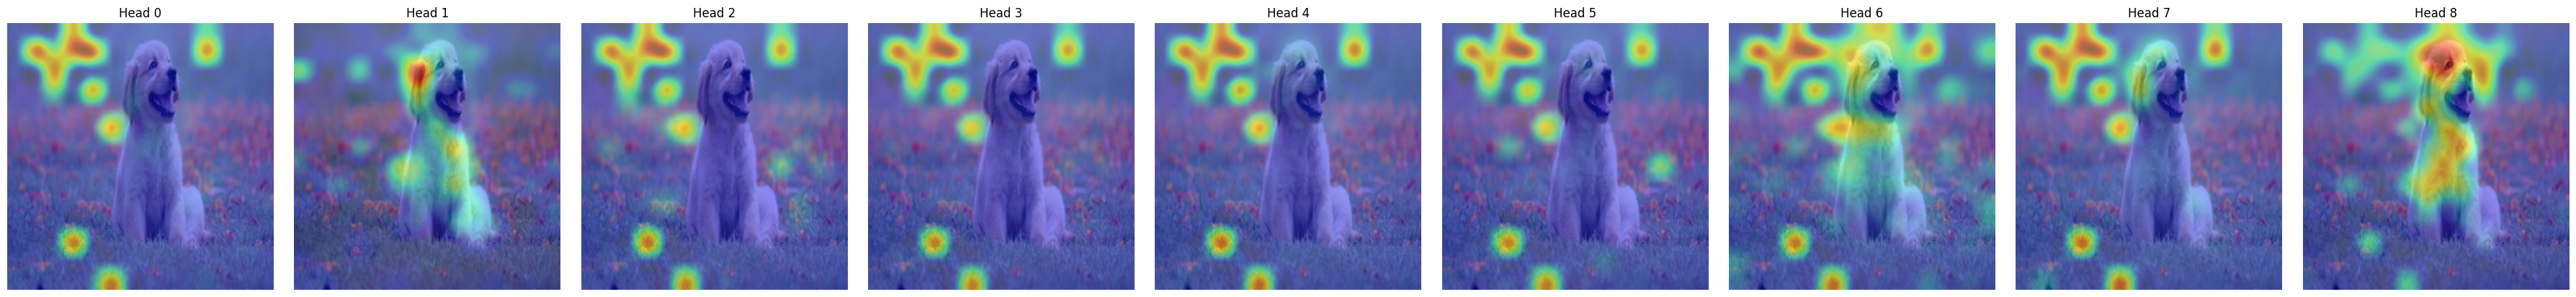

In [ ]:
# --- Visualize first three heads (0,1,2) of the last layer for the dog image ---

# pick the dog image (change index if needed)
dog_idx = 0
dog_img = images[dog_idx]

# get attentions from the backbone you loaded earlier: vit_backbone
inputs = processor(images=dog_img, return_tensors="pt").to(device)
with torch.no_grad():
    out = vit_backbone(**inputs)   # output_attentions=True was set when loading

# last layer attentions: (heads, seq, seq) for batch 0
att_last = out.attentions[-1][0]   # shape: [num_heads, seq, seq]

# patch grid size
img_size = vit_backbone.config.image_size
patch = vit_backbone.config.patch_size
Hp = Wp = img_size // patch

# which heads to show
heads_to_show = [0, 1, 2, 3, 4, 5, 6, 7, 8]

# plot
fig, axs = plt.subplots(1, len(heads_to_show), figsize=(4*len(heads_to_show), 4))
axs = np.atleast_1d(axs)

for ax, h in zip(axs, heads_to_show):
    # CLS (row 0) attention to patch tokens (cols 1..)
    cls2patch = att_last[h, 0, 1:].reshape(1, 1, Hp, Wp)

    # normalize to [0,1]
    cls2patch = cls2patch - cls2patch.min()
    cls2patch = cls2patch / (cls2patch.max() + 1e-6)

    # upsample to image size for overlay
    heat_up = F.interpolate(cls2patch, size=(img_size, img_size), mode="bicubic", align_corners=False)
    heat = heat_up.squeeze().cpu().numpy()

    # show
    ax.imshow(dog_img.resize((img_size, img_size), Image.BICUBIC))
    ax.imshow(heat, cmap="jet", alpha=0.45, interpolation="bilinear")
    ax.set_title(f"Head {h}")
    ax.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
# 4) Mask a fraction of input patches at inference

# === Part 4 (using YOUR images): mask patches at inference & compare predictions ===
# Reuses: model, processor, images, device from Parts 1–2

import math, os
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from PIL import Image, ImageDraw

os.makedirs("artifacts_inputimgs/overlays", exist_ok=True)
id2label = model.config.id2label

# 1) Prep: get baseline predictions (unmasked)
with torch.no_grad():
    base_inputs = processor(images=images, return_tensors="pt").to(device)
    base_logits = model(**base_inputs).logits
    base_probs = base_logits.softmax(dim=-1).cpu()
    base_top1  = base_probs.argmax(dim=-1)

# 2) Mask builders (on the 224x224 processed tensor, aligned with model patches)
P = model.config.patch_size           # e.g., 16
H, W = model.config.image_size, model.config.image_size
gh, gw = H // P, W // P               # patch grid size
num_patches = gh * gw

def build_mask_indices(frac, mode, gh, gw, seed=1234):
    """Return a 1D LongTensor with indices in [0, gh*gw). Allows k=0."""
    k = int(round(frac * (gh*gw)))
    if k <= 0:
        return torch.empty(0, dtype=torch.long)
    grid = torch.arange(gh*gw).reshape(gh, gw)
    if mode == "random":
        g = torch.Generator().manual_seed(seed)
        return torch.randperm(gh*gw, generator=g)[:k]
    elif mode == "center":
        side = max(1, min(gh, gw, int(round(math.sqrt(k)))))
        r0, c0 = (gh - side) // 2, (gw - side) // 2
        block = grid[r0:r0+side, c0:c0+side].reshape(-1)
        return block[:k]  # trim if side*side > k
    else:
        raise ValueError("mode must be 'random' or 'center'")

def apply_mask_pixels(pixel_values, idxs):
    """Zero out selected patch blocks in pixel space. pixel_values: [1,3,H,W]"""
    pv = pixel_values.clone()
    for n in idxs.tolist():
        r, c = divmod(n, gw)
        y0, y1 = r*P, (r+1)*P
        x0, x1 = c*P, (c+1)*P
        pv[0, :, y0:y1, x0:x1] = 0.0
    return pv

def overlay_mask_on_image(img_pil, idxs, save_path=None, draw_grid=False):
    """Visual sanity check: draws masked patches on the *resized* image."""
    base = img_pil.resize((W, H)).convert("RGBA")
    ov = Image.new("RGBA", (W, H), (0,0,0,0))
    d = ImageDraw.Draw(ov)
    for n in idxs.tolist():
        r, c = divmod(n, gw)
        x0, y0 = c*P, r*P
        x1, y1 = x0+P-1, y0+P-1
        d.rectangle([x0,y0,x1,y1], fill=(0,0,0,120))
    if draw_grid:
        for r in range(gh+1): d.line([(0,r*P),(W,r*P)], fill=(255,255,255,60))
        for c in range(gw+1): d.line([(c*P,0),(c*P,H)], fill=(255,255,255,60))
    comp = Image.alpha_composite(base, ov)
    if save_path: comp.save(save_path)
    return comp

# 3) Evaluate per-image for chosen fractions & modes
fractions = [0.0, 0.1, 0.3, 0.5]
modes = ["random", "center"]

rows = []
for i, img in enumerate(images):
    # per-image baseline
    b_cls = int(base_top1[i].item())
    b_lab = id2label[b_cls]
    b_prob = float(base_probs[i, b_cls].item())

    for mode in modes:
        for f in fractions:
            idxs = build_mask_indices(f, mode, gh, gw, seed=1234 + i*17 + int(f*100))
            # optional: save an overlay for exactly this mask
            overlay_mask_on_image(img, idxs, save_path=f"artifacts_inputimgs/overlays/img{i+1}_{mode}_f{int(f*100)}.png")

            # run masked inference
            inputs_i = processor(images=img, return_tensors="pt").to(device)
            masked = apply_mask_pixels(inputs_i["pixel_values"], idxs)
            with torch.no_grad():
                logits_m = model(pixel_values=masked).logits.cpu()
                probs_m = logits_m.softmax(dim=-1)

            m_cls = int(probs_m.argmax(dim=-1).item())
            m_lab = id2label[m_cls]
            m_prob = float(probs_m[0, m_cls].item())
            # how much did confidence in the *baseline* class drop?
            delta = float((base_probs[i, b_cls] - probs_m[0, b_cls]).item())
            flip = int(m_cls != b_cls)
            achieved_frac = len(idxs) / num_patches

            rows.append({
                "image": i+1,
                "mode": mode,
                "masked_frac_requested": f,
                "masked_frac_achieved": round(achieved_frac, 3),
                "baseline_top1": b_lab,
                "baseline_prob": round(b_prob, 3),
                "masked_top1": m_lab,
                "masked_prob": round(m_prob, 3),
                "Δprob(baseline_cls)": round(delta, 3),
                "top1_flip": flip
            })

# 4) Show per-image table and an aggregate summary
df = pd.DataFrame(rows).sort_values(["image", "mode", "masked_frac_requested"]).reset_index(drop=True)
agg = (df.groupby(["mode", "masked_frac_requested"])
         .agg(mean_Δprob=("Δprob(baseline_cls)", "mean"),
              flip_rate=("top1_flip", "mean"),
              avg_achieved_frac=("masked_frac_achieved","mean"))
         .reset_index())

print("\n=== Per-image robustness (your images) ===")
print(df.to_string(index=False))

print("\n=== Aggregate summary over your images ===")
print(agg.to_string(index=False))

print("\nOverlays saved to artifacts_inputimgs/overlays/ (one per image × mode × fraction)")





=== Per-image robustness (your images) ===
 image   mode  masked_frac_requested  masked_frac_achieved    baseline_top1  baseline_prob                masked_top1  masked_prob  Δprob(baseline_cls)  top1_flip
     1 center                    0.0                 0.000 golden retriever          0.888           golden retriever        0.888               -0.000          0
     1 center                    0.1                 0.082 golden retriever          0.888           golden retriever        0.415                0.473          0
     1 center                    0.3                 0.301 golden retriever          0.888           golden retriever        0.385                0.503          0
     1 center                    0.5                 0.500 golden retriever          0.888 skunk, polecat, wood pussy        0.382                0.868          1
     1 random                    0.0                 0.000 golden retriever          0.888           golden retriever        0.888           

image – which of your images (1 = dog, 2 = cat).

mode – how we mask:

center: a contiguous square in the middle.

random: the same number of patches, scattered.

masked_frac_requested – the fraction you asked to mask (e.g., 0.3).

masked_frac_achieved – the actual masked fraction. For center, we mask a square; its area can only hit certain multiples of patch count, so it may be ~0.082, 0.301, 0.500 rather than exactly 0.1/0.3/0.5. We report the true achieved value to be transparent.

baseline_top1 / baseline_prob – the model’s unmasked prediction and its confidence.

masked_top1 / masked_prob – the model’s prediction and confidence after masking.

Δprob(baseline_cls) – drop in confidence for the original (baseline) class after masking.
Positive numbers mean masking reduced belief in the original class; larger = more damaging.

top1_flip – 1 if the top-1 label changed after masking, 0 if it stayed the same.



Interpreting Image 1 (dog)

Baseline: “golden retriever” (p=0.888).

Random 0.1 / 0.3: tiny confidence drop (Δ≈0.055–0.060), no flip.
Randomly removing scattered patches leaves enough evidence; ViT aggregates global context.

Center 0.1 / 0.3: much bigger drop (Δ≈0.47–0.50), still no flip yet.
A central hole removes contiguous, likely object-centric evidence (dog’s face/body).

At 0.5 masked:

Random: flips to “standard poodle” (Δ≈0.881). Still a dog class—semantic neighbor.

Center: flips to “skunk/polecat” (Δ≈0.868). A large central hole nudges the model toward a spurious background cue.

Takeaway: center masking hurts earlier and more severely; random masking is more graceful.

Interpreting Image 2 (cat)

Baseline: “lynx/catamount” (p=0.509).

Center 0.1: already flips to “Egyptian cat” (Δ≈0.219).
Even a small central hole corrupts the key facial textures/patterns.

Center 0.3–0.5: stays on cat breeds but not the baseline one; confidence in the original class drops a lot (Δ≈0.48–0.50).

Random 0.1: small drop, no flip.
Random 0.3–0.5: flips to “Egyptian cat” or “Persian cat” (again, cat-breed neighbors).

Takeaway: when evidence is concentrated (cat face), even modest center occlusion triggers a class change; random needs more masking to flip.

Why this behavior is expected

Random masking removes distributed patches; ViT’s self-attention can still integrate remaining cues, so degradation is gradual.

Center masking removes a contiguous region; most natural images place the object centrally, so this wipes out a large chunk of correlated, discriminative tokens—confidence drops faster and flips occur earlier.

Flips to “neighbor” classes (golden retriever → poodle; lynx → Egyptian/Persian) show the model stays within the semantic neighborhood when evidence is degraded—another sanity check.

In [ ]:
# === Part 5: Linear probes — CLS vs Mean of Patch Tokens (CIFAR-10) ===
# Keeps it minimal: frozen ViT → features → two sklearn logistic regressions → compare.

import numpy as np
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from transformers import AutoImageProcessor, ViTModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pandas as pd
from tqdm import tqdm

# 0) Config
MODEL_NAME = "google/vit-base-patch16-224"  # ImageNet-pretrained ViT
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42
TRAIN_MAX = 5000   # number of CIFAR-10 train examples to use (keep small for speed)
TEST_MAX  = 2000   # number of CIFAR-10 test examples to use
BATCH = 128
LAYER_IDX = -1     # -1 = last layer features; set to -2 to probe penultimate if you want

torch.manual_seed(SEED); np.random.seed(SEED)

# 1) Backbone + processor (frozen)
processor = AutoImageProcessor.from_pretrained(MODEL_NAME)
vit = ViTModel.from_pretrained(MODEL_NAME).to(DEVICE).eval()
for p in vit.parameters():
    p.requires_grad = False

# 2) CIFAR-10 loaders (processor handles resize/normalize to 224 for ViT)
def collate(batch):
    pil_imgs = [transforms.ToPILImage()(x[0]) for x in batch]
    labels = torch.tensor([x[1] for x in batch], dtype=torch.long)
    px = processor(images=pil_imgs, return_tensors="pt")["pixel_values"]
    return px, labels

def make_loader(split="train", max_items=None, shuffle=False):
    ds = datasets.CIFAR10(root="./data", train=(split=="train"),
                          download=True, transform=transforms.ToTensor())
    if max_items is not None:
        ds = Subset(ds, list(range(max_items)))
    return DataLoader(ds, batch_size=BATCH, shuffle=shuffle, num_workers=2,
                      pin_memory=True, collate_fn=collate)

train_loader = make_loader("train", max_items=TRAIN_MAX, shuffle=True)
test_loader  = make_loader("test",  max_items=TEST_MAX,  shuffle=False)

# 3) Feature extraction: CLS vs mean of patch tokens
@torch.no_grad()
def extract_features(loader, layer_idx=LAYER_IDX):
    X_cls, X_mean, Y = [], [], []
    img_size = vit.config.image_size
    psize = vit.config.patch_size
    Hp = Wp = img_size // psize
    num_patches = Hp * Wp

    for px, y in tqdm(loader, desc="Extract features"):
        px = px.to(DEVICE)
        if layer_idx == -1:
            H = vit(pixel_values=px).last_hidden_state            # [B, 1+N, D] (last layer)
        else:
            out = vit(pixel_values=px, output_hidden_states=True)
            H = out.hidden_states[layer_idx]                      # chosen layer
        # CLS token
        f_cls = H[:, 0, :]                                        # [B, D]
        # Mean over *patch tokens only* (exclude special tokens): take last num_patches
        f_mean = H[:, -num_patches:, :].mean(dim=1)               # [B, D]
        X_cls.append(f_cls.cpu().numpy())
        X_mean.append(f_mean.cpu().numpy())
        Y.append(y.numpy())
    return np.vstack(X_cls), np.vstack(X_mean), np.concatenate(Y)

Xtr_cls, Xtr_mean, ytr = extract_features(train_loader)
Xte_cls, Xte_mean, yte = extract_features(test_loader)

# 4) Two identical linear probes (sklearn logistic regression)
def fit_probe(X, y, C=1.0, max_iter=300):
    clf = LogisticRegression(
        C=C, max_iter=max_iter, solver="lbfgs",
        multi_class="multinomial", n_jobs=-1, random_state=SEED
    )
    clf.fit(X, y)
    return clf

probe_cls  = fit_probe(Xtr_cls,  ytr)
probe_mean = fit_probe(Xtr_mean, ytr)

acc_cls  = accuracy_score(yte, probe_cls.predict(Xte_cls))
acc_mean = accuracy_score(yte, probe_mean.predict(Xte_mean))

# 5) Tiny comparison table
df = pd.DataFrame([
    {"probe": "CLS token",       "test_accuracy": round(acc_cls,  4)},
    {"probe": "Mean of patches", "test_accuracy": round(acc_mean, 4)},
])
df["Δ vs CLS"] = (df["test_accuracy"] - acc_cls).round(4)

print("\n=== Part 5: Linear probe comparison (frozen ViT, CIFAR-10) ===")
print(df.to_string(index=False))

# (Optional) Also print which layer you used
layer_name = "last" if LAYER_IDX == -1 else ("penultimate (L-1)" if LAYER_IDX == -2 else f"layer {LAYER_IDX}")
print(f"\nFeatures from: {layer_name}.  (Set LAYER_IDX=-2 to probe L-1 if you like.)")


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Extract features: 100%|██████████| 16/16 [00:22<00:00,  1.40s/it]
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



=== Part 5: Linear probe comparison (frozen ViT, CIFAR-10) ===
          probe  test_accuracy  Δ vs CLS
      CLS token         0.9665    0.0000
Mean of patches         0.9710    0.0045

Features from: last.  (Set LAYER_IDX=-2 to probe L-1 if you like.)


Notes for your write-up (brief):

With supervised ImageNet pretraining (this ViT), the CLS probe often edges out mean-pool because the pretraining loss pushes global evidence into CLS.

Under token-centric pretraining (e.g., MAE/BEiT), information is more distributed across patch tokens → mean/attention pooling can win.

You can flip LAYER_IDX=-2 to probe penultimate (L-1) features as a small extra check.

CLS probe (last layer): 96.65%

Mean of patch tokens (last layer): 97.10% → +0.45 pp better

What this means (in plain English)

Both numbers are high → the frozen ViT features transfer very well to CIFAR-10.

Mean-pool wins (slightly). That suggests, for this task, useful class evidence is spread across many patches, and averaging those tokens gives a cleaner, more linearly separable signal than relying on the single CLS token.

Why could mean-pool beat CLS here?

CIFAR-10 images are tiny (32→224 upscale): object cues are fine-grained and distributed; averaging tokens preserves these distributed signals.

Last-layer CLS is optimized for ImageNet (global, large images). On CIFAR-10, its “global summary” can be a bit over-specialized to ImageNet biases.

Robustness: mean-pool tends to be slightly more stable to nuisance/background variation, which helps linear separability.